In [1]:
import numpy as np 
import pandas as pd
import lightgbm as lgb
import random
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
path = 'C:/test/work/ppd/data'

In [2]:
# Master数据
df1 = pd.read_csv(path+'/feature_select_data1.csv',encoding='gb18030')
df1.shape

(49101, 162)

In [4]:
# 排序特征数据
rank_df = pd.read_csv(path+'/rank_feature.csv',encoding='gbk')
rank_df.shape

(49101, 137)

In [7]:
# periods衍生特征数据
periods_df = pd.read_csv(path+'/periods_feature.csv',encoding='gbk')
periods_df.shape

(49101, 51)

In [8]:
# 原生特征（不含排序特征和periods衍生特征）
feature1 = list(df1.columns)
# 排序特征和periods衍生特征
feature2 = list(rank_df.columns)+list(periods_df.columns)

In [9]:
# 对feature2进行随机打乱顺序
random.shuffle(feature2)

In [10]:
# 合并数据集
df = pd.concat([df1,rank_df,periods_df],axis=1)
df.shape

(49101, 350)

In [11]:
# 保存用户id
data_idx = df.Idx

In [12]:
# 定义lightgbm的bagging函数
def bagging_lightgbm(feature_fraction,bagging_fraction,ramdom_seed,n_feature):
    
    select_fea = feature1+feature2[:n_feature]
    
    data = df.loc[:,select_fea]
    train_x = data[data.sample_status=='train'].drop(['sample_status','target','Idx'],axis=1)
    train_y = data[data.sample_status=='train']['target']
    test_x = data[data.sample_status=='test'].drop(['sample_status','target','Idx'],axis=1)
    test_y = data[data.sample_status=='test']['target']
    
    test_user_id = list(data[data.sample_status=='test']['Idx'])
    
    
    dtrain = lgb.Dataset(train_x,train_y)
    dtest = lgb.Dataset(test_x,test_y)
    
    params={
        'boosting_type':'gbdt',
        'metric':'auc',
        'num_leaves':30,
        'min_data_in_leaf':20,
        'min_sum_hessian_in_leaf':0.001,
        'bagging_fraction':bagging_fraction,
        'feature_fraction':feature_fraction,
        'learning_rate':0.005,
    }
    
    #  寻找最佳的迭代次数
    cv_result = lgb.cv(train_set=dtrain,
                       early_stopping_rounds=10,
                       num_boost_round=1000,
                       nfold=5,
                       metrics='auc',
                       seed=0,
                       params=params,
                       stratified=True,
                       shuffle=True)
    max_auc = max(cv_result['auc-mean'])
    num_round = len(cv_result['auc-mean'])
    
    model = lgb.train(train_set=dtrain,early_stopping_rounds=10,num_boost_round=num_round,valid_sets=dtest,params=params)
    
    model_pre = list(model.predict(test_x))
    result_df = pd.DataFrame({'Idx':test_user_id,
                              'score':model_pre})
    return result_df

# 对随机种子，bagging_fraction，feature_fraction及特征数量进行随机扰动
random_seed = list(range(2018))
bagging_fraction = [i/1000.0 for i in range(500,1000)]
feature_fraction = [i/1000.0 for i in range(500,1000)]
n_feature = list(range(50,174,2))

random.shuffle(random_seed)
random.shuffle(bagging_fraction)
random.shuffle(feature_fraction)
random.shuffle(n_feature)

In [13]:
import time 
a=  time.time()
result_df_list=[]
# 建立30个子模型，保存各个子模型输出的结果
for i in range(30):
    result_df = bagging_lightgbm(feature_fraction=feature_fraction[i],
                                 n_feature=n_feature[i],
                                 ramdom_seed=random_seed[i],
                                 bagging_fraction=bagging_fraction[i])
    result_df_list.append(result_df)
# 对30个子模型的结果average，得到bagging模型的最终结果
prep_list = [list(x['prep']) for x in result_df_list]
bagging_prep= list(np.sum(score_list,axis=0)/30)
b = time.time()
print('运行时间:{}'.format(round(b-a,0)))

[1]	valid_0's auc: 0.649208
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.673189
[3]	valid_0's auc: 0.674785
[4]	valid_0's auc: 0.673793
[5]	valid_0's auc: 0.674191
[6]	valid_0's auc: 0.673925
[7]	valid_0's auc: 0.673491
[8]	valid_0's auc: 0.670844
[9]	valid_0's auc: 0.671184
[10]	valid_0's auc: 0.676132
[11]	valid_0's auc: 0.676142
[12]	valid_0's auc: 0.676535
[13]	valid_0's auc: 0.677095
[14]	valid_0's auc: 0.679997
[15]	valid_0's auc: 0.67948
[16]	valid_0's auc: 0.679652
[17]	valid_0's auc: 0.679672
[18]	valid_0's auc: 0.679854
[19]	valid_0's auc: 0.679789
[20]	valid_0's auc: 0.681042
[21]	valid_0's auc: 0.681246
[22]	valid_0's auc: 0.682171
[23]	valid_0's auc: 0.685093
[24]	valid_0's auc: 0.685773
[25]	valid_0's auc: 0.686412
[26]	valid_0's auc: 0.68808
[27]	valid_0's auc: 0.689352
[28]	valid_0's auc: 0.689901
[29]	valid_0's auc: 0.690771
[30]	valid_0's auc: 0.691178
[31]	valid_0's auc: 0.691085
[32]	valid_0's auc: 0.692137
[33]	valid_0's auc: 0

[278]	valid_0's auc: 0.732417
[279]	valid_0's auc: 0.732436
[280]	valid_0's auc: 0.732575
[281]	valid_0's auc: 0.732582
[282]	valid_0's auc: 0.732777
[283]	valid_0's auc: 0.732866
[284]	valid_0's auc: 0.73288
[285]	valid_0's auc: 0.733002
[286]	valid_0's auc: 0.733001
[287]	valid_0's auc: 0.732971
[288]	valid_0's auc: 0.733109
[289]	valid_0's auc: 0.733287
[290]	valid_0's auc: 0.733344
[291]	valid_0's auc: 0.733386
[292]	valid_0's auc: 0.733456
[293]	valid_0's auc: 0.733521
[294]	valid_0's auc: 0.733505
[295]	valid_0's auc: 0.733593
[296]	valid_0's auc: 0.733587
[297]	valid_0's auc: 0.733786
[298]	valid_0's auc: 0.733928
[299]	valid_0's auc: 0.734117
[300]	valid_0's auc: 0.734248
[301]	valid_0's auc: 0.734288
[302]	valid_0's auc: 0.734466
[303]	valid_0's auc: 0.734515
[304]	valid_0's auc: 0.734566
[305]	valid_0's auc: 0.734563
[306]	valid_0's auc: 0.734764
[307]	valid_0's auc: 0.734877
[308]	valid_0's auc: 0.734874
[309]	valid_0's auc: 0.735028
[310]	valid_0's auc: 0.73513
[311]	valid_

[555]	valid_0's auc: 0.747793
[556]	valid_0's auc: 0.747804
[557]	valid_0's auc: 0.747827
[558]	valid_0's auc: 0.747846
[559]	valid_0's auc: 0.747842
[560]	valid_0's auc: 0.747832
[561]	valid_0's auc: 0.747864
[562]	valid_0's auc: 0.74785
[563]	valid_0's auc: 0.747877
[564]	valid_0's auc: 0.747908
[565]	valid_0's auc: 0.747881
[566]	valid_0's auc: 0.747896
[567]	valid_0's auc: 0.747952
[568]	valid_0's auc: 0.747944
[569]	valid_0's auc: 0.747958
[570]	valid_0's auc: 0.748003
[571]	valid_0's auc: 0.747989
[572]	valid_0's auc: 0.748068
[573]	valid_0's auc: 0.748111
[574]	valid_0's auc: 0.748164
[575]	valid_0's auc: 0.748228
[576]	valid_0's auc: 0.748274
[577]	valid_0's auc: 0.748351
[578]	valid_0's auc: 0.748347
[579]	valid_0's auc: 0.748378
[580]	valid_0's auc: 0.748342
[581]	valid_0's auc: 0.748398
[582]	valid_0's auc: 0.74845
[583]	valid_0's auc: 0.748455
[584]	valid_0's auc: 0.748505
[585]	valid_0's auc: 0.748547
[586]	valid_0's auc: 0.748531
[587]	valid_0's auc: 0.748552
[588]	valid_

[835]	valid_0's auc: 0.753721
[836]	valid_0's auc: 0.753746
[837]	valid_0's auc: 0.753777
[838]	valid_0's auc: 0.75373
[839]	valid_0's auc: 0.753727
[840]	valid_0's auc: 0.753759
[841]	valid_0's auc: 0.753804
[842]	valid_0's auc: 0.753814
[843]	valid_0's auc: 0.753792
[844]	valid_0's auc: 0.753839
[845]	valid_0's auc: 0.753824
[846]	valid_0's auc: 0.753816
[847]	valid_0's auc: 0.75385
[848]	valid_0's auc: 0.753816
[849]	valid_0's auc: 0.753803
[850]	valid_0's auc: 0.753846
[851]	valid_0's auc: 0.753855
[852]	valid_0's auc: 0.753848
[853]	valid_0's auc: 0.753856
[854]	valid_0's auc: 0.753867
[855]	valid_0's auc: 0.753896
[856]	valid_0's auc: 0.753911
[857]	valid_0's auc: 0.753905
[858]	valid_0's auc: 0.753925
[859]	valid_0's auc: 0.753925
[860]	valid_0's auc: 0.753982
[861]	valid_0's auc: 0.754024
[862]	valid_0's auc: 0.754043
[863]	valid_0's auc: 0.75406
[864]	valid_0's auc: 0.754055
[865]	valid_0's auc: 0.754036
[866]	valid_0's auc: 0.754033
[867]	valid_0's auc: 0.754062
[868]	valid_0

[140]	valid_0's auc: 0.721328
[141]	valid_0's auc: 0.721526
[142]	valid_0's auc: 0.721791
[143]	valid_0's auc: 0.721795
[144]	valid_0's auc: 0.721985
[145]	valid_0's auc: 0.722267
[146]	valid_0's auc: 0.722401
[147]	valid_0's auc: 0.722383
[148]	valid_0's auc: 0.722513
[149]	valid_0's auc: 0.72258
[150]	valid_0's auc: 0.722699
[151]	valid_0's auc: 0.722865
[152]	valid_0's auc: 0.722915
[153]	valid_0's auc: 0.722876
[154]	valid_0's auc: 0.723296
[155]	valid_0's auc: 0.723351
[156]	valid_0's auc: 0.723613
[157]	valid_0's auc: 0.723671
[158]	valid_0's auc: 0.723816
[159]	valid_0's auc: 0.723827
[160]	valid_0's auc: 0.72416
[161]	valid_0's auc: 0.724486
[162]	valid_0's auc: 0.724677
[163]	valid_0's auc: 0.724751
[164]	valid_0's auc: 0.724911
[165]	valid_0's auc: 0.725018
[166]	valid_0's auc: 0.72507
[167]	valid_0's auc: 0.725394
[168]	valid_0's auc: 0.725601
[169]	valid_0's auc: 0.725742
[170]	valid_0's auc: 0.725808
[171]	valid_0's auc: 0.72608
[172]	valid_0's auc: 0.72612
[173]	valid_0's

[415]	valid_0's auc: 0.744485
[416]	valid_0's auc: 0.744578
[417]	valid_0's auc: 0.744589
[418]	valid_0's auc: 0.744605
[419]	valid_0's auc: 0.744612
[420]	valid_0's auc: 0.744613
[421]	valid_0's auc: 0.744738
[422]	valid_0's auc: 0.744749
[423]	valid_0's auc: 0.744856
[424]	valid_0's auc: 0.744849
[425]	valid_0's auc: 0.744859
[426]	valid_0's auc: 0.744953
[427]	valid_0's auc: 0.745018
[428]	valid_0's auc: 0.745026
[429]	valid_0's auc: 0.745041
[430]	valid_0's auc: 0.745104
[431]	valid_0's auc: 0.745184
[432]	valid_0's auc: 0.745157
[433]	valid_0's auc: 0.745149
[434]	valid_0's auc: 0.745183
[435]	valid_0's auc: 0.745178
[436]	valid_0's auc: 0.745146
[437]	valid_0's auc: 0.745188
[438]	valid_0's auc: 0.74525
[439]	valid_0's auc: 0.745324
[440]	valid_0's auc: 0.745356
[441]	valid_0's auc: 0.745354
[442]	valid_0's auc: 0.745446
[443]	valid_0's auc: 0.745439
[444]	valid_0's auc: 0.745575
[445]	valid_0's auc: 0.745614
[446]	valid_0's auc: 0.745663
[447]	valid_0's auc: 0.745735
[448]	valid

KeyboardInterrupt: 

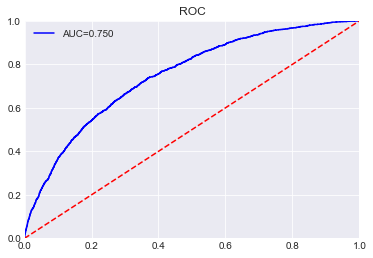

In [103]:
# bagging模型的AUC
test_y = list(df[df.sample_status=='test']['target'])
print('lightgbm单模型的AUC：{}'.format(metrics.roc_auc_score(test_y,bagging_prep)))
fpr,tpr,_=roc_curve(test_y,bagging_prep)
plt.plot(fpr, tpr, color = 'c')
plt.plot([0,1],[0,1], color = 'r', linestyle='--')